In [1]:
! pip install scikit-uplift
! pip install catboost
! pip install causalml

import numpy as np
import pandas as pd

from IPython.display import Image

from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels

from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from catboost import CatBoostClassifier

     |████████████████████████████████| 67.4 MB 26 kB/s 
     |████████████████████████████████| 243 kB 36.1 MB/s 
     |████████████████████████████████| 326 kB 48.1 MB/s 
     |████████████████████████████████| 1.8 MB 52.4 MB/s 
     |████████████████████████████████| 678 kB 34.9 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496315 sha256=472f71ace45542451561b68bcfb87d30318fd08e16533e3364e4a875e5dc408e
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465071 sha256=285fb7b0c02b04d26a990310d6378659cdea6da4f1da1f90edcbe8a2c7b0cf00
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Задание 1

Скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention.

In [3]:
df = pd.read_csv('data.csv', delimiter=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [4]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [5]:
df['conversion'].value_counts()

0    54606
1     9394
Name: conversion, dtype: int64

In [6]:
df['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

Задание 2
Поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.


In [7]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})


Приводим в бинарный вид и удаляем признак treatment_No Offer - он не дает никакой дополнительной информации, т.к. нули в 2-х других признаках автоматически означают No Offer.

In [8]:
df.loc[df['treatment'] != 'No Offer', 'treatment'] = 1
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df['treatment'] = df['treatment'].astype(np.int)



In [9]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


Задание 3
Сделать разбиение набора данных не тренировочную и тестовую выборки.

In [10]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(df.drop(columns=['target', 'treatment']), 
                                                            df['target'],
                                                            df['treatment'],
                                                            random_state=0)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, treat_train.shape

((48000, 7), (16000, 7), (48000,), (16000,), (48000,))

Задание 4

Сделать feature engineering на ваше усмотрение (допускается свобода выбора методов).

In [12]:
df['history'].describe()

count    64000.000000
mean       242.085656
std        256.158608
min         29.990000
25%         64.660000
50%        158.110000
75%        325.657500
max       3345.930000
Name: history, dtype: float64

Пусть китами будут пользователи с покупками на сумму >= 1000, дельфинами - на сумму 200-1000, пескари - < 200.

In [13]:
def segment_customers(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['customer_is_whale'] = 0
    df['customer_is_dolphin'] = 0
    df['customer_is_minnow'] = 0
    df.loc[df['history'] >= 1000, 'customer_is_whale'] = 1
    df.loc[(df['history'] < 1000) & (df['history'] >= 200), 'customer_is_dolphin'] = 1
    df.loc[df['history'] < 200, 'customer_is_minnow'] = 1
    return df

In [14]:
X_train = segment_customers(X_train)
X_test = segment_customers(X_test)
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,customer_is_whale,customer_is_dolphin,customer_is_minnow
1098,8,63.58,1,0,Surburban,1,Phone,0,0,1
13764,3,395.35,1,0,Surburban,1,Web,0,1,0
45116,4,1307.99,1,1,Rural,1,Phone,1,0,0
15363,10,159.01,0,1,Surburban,1,Web,0,0,1
44498,1,276.00,1,0,Urban,0,Phone,0,1,0


Задание 5

Провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями.

In [15]:
metrics_df = pd.DataFrame(columns=['uplift@10%', 'uplift@20%'])

Категориальные признаки


In [16]:
cat_features = ['zip_code', 'channel']

Solo Learner

In [17]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)
print(uplift_sm)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

[0.06432045 0.07542487 0.07740249 ... 0.08154219 0.04320785 0.08773974]


Сохраняем метрики модели.

In [18]:
metrics_df = metrics_df.append({'uplift@10%': sm_score_10, 'uplift@20%': sm_score_20}, ignore_index=True)

Transform Learner

In [19]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)
print(uplift_ct)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


[-0.15984896 -0.17517973 -0.14598457 ... -0.16268689 -0.1697486
 -0.07295668]


Сохраняем метрики модели.

In [20]:
metrics_df = metrics_df.append({'uplift@10%': ct_score_10, 'uplift@20%': ct_score_20}, ignore_index=True)

Two Model Learner

In [21]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)
print(uplift_tm)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

[0.08574949 0.08029174 0.09133908 ... 0.07039956 0.0432995  0.12032493]


Сохраняем метрики модели.

In [22]:
metrics_df = metrics_df.append({'uplift@10%': tm_score_10, 'uplift@20%': tm_score_20}, ignore_index=True)

Задание 6

В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей.

In [23]:
metrics_df

,uplift@10%,uplift@20%
0,0.063826,0.064139
1,0.073137,0.061024
2,0.079349,0.065813


Задание 7

Построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево.

In [24]:
def transform_data_to_tree(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = pd.get_dummies(df, drop_first=True)
    return df

In [25]:
X_train_tree = transform_data_to_tree(X_train)
X_test_tree = transform_data_to_tree(X_test)
features = [col for col in X_train_tree]

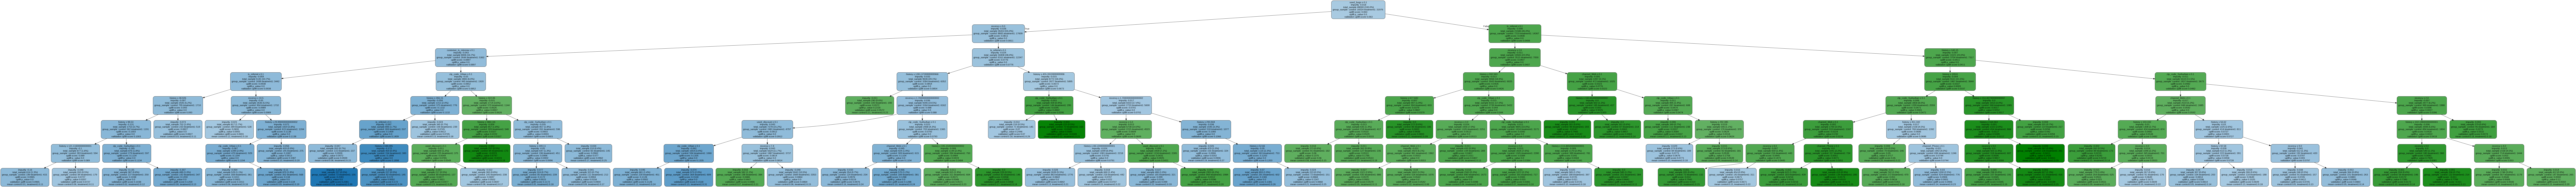

In [26]:
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Можно выделить некоторые сегменты:

Городские жители, давно не покупавшие и использовавшие предложение Buy One Get One с суммой покупок 322-388 - для них веротность конверсии ухудшится при коммуникации.

Клиенты, использовавшие предложение BOGO, которые недавно покупали у нас и имеют общую сумму покупок < 52.5 - для них коммуникация повысит шанс конверсии.

Пригородные жители не по рефералам, покупающие по телефону, с общей суммой покупок > 200 - для них коммуникация повысит шанс конверсии.